In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.constants
import astropy.units as apu
import astropy.cosmology
from astropy.coordinates import SkyCoord
import borg_velocity.poisson_process as poisson_process
from astropy.cosmology import LambdaCDM, z_at_value
import jax.numpy as jnp

import importlib
import tfr_inference
importlib.reload(tfr_inference)

/home/bartlett/fsigma8/borg_velocity/tests/tfr_inference.py:310: SyntaxWarning: invalid escape sequence '\s'
  sigma_m = np.median(df['e_Kmag'])


<module 'tfr_inference' from '/home/bartlett/fsigma8/borg_velocity/tests/tfr_inference.py'>

0.0028092475228007545 0.04950413092258361 0.011837616297618123 0.009863123740916042
335 9990


<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_13422/2464123570.py:3: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(fname, sep='\s+', names=columns)


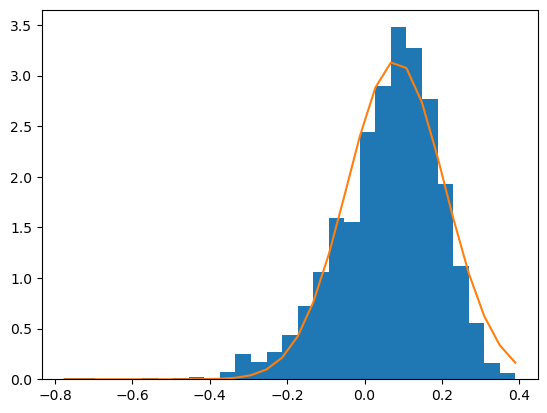

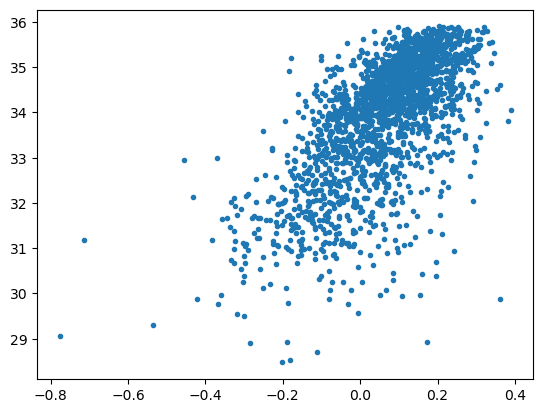

In [29]:
columns = ['ID', 'RAdeg', 'DEdeg', 'cz2mrs', 'Kmag', 'Hmag', 'Jmag', 'e_Kmag', 'e_Hmah', 'e_Jmag', 'WHIc', 'e_WHIc']
fname = '/data101/bartlett/fsigma8/PV_data/2MASS/table1.dat'
df = pd.read_csv(fname, sep='\s+', names=columns)
    
eta = np.log10(df['WHIc']) - 2.5

bins = np.linspace(eta.min(), eta.max(), 30)
plt.hist(eta, bins=bins, density=True)

mu = np.median(eta)
sigma = (np.percentile(eta, 84) - np.percentile(eta, 16)) / 2
g = np.exp(- (bins - mu) ** 2 / 2 / sigma**2) / np.sqrt(2 * np.pi) / sigma
plt.plot(bins, g)

sigma_eta = df['e_WHIc'] / df['WHIc'] / np.log(10)
print(sigma_eta.min(), sigma_eta.max(), sigma_eta.mean(), sigma_eta.median())

print(df['cz2mrs'].min(),  df['cz2mrs'].max())
z = df['cz2mrs'] / astropy.constants.c.to('km/s').value
cosmo = astropy.cosmology.Planck18
dL = cosmo.luminosity_distance(z).to(apu.Mpc).value # Mpc
mu = 5 * np.log10(dL) + 25

plt.figure()
plt.plot(eta, mu, '.')

<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_13422/2032762086.py:20: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(fname, sep='\s+', names=columns)
/tmp/ipykernel_13422/2032762086.py:34: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(fname, sep='\s+', names=columns)


zcosmo 0.0039389587876126975 0.05462965177877669
etatrue: -0.41705506563366274 0.5555464714961542
muTFR 31.441390386741705 37.174221031390445
mutrue 30.852170311886482 36.64413989655261
sigma_TFR 0.3
mtrue 5.590206617138733 16.490061642329344


Text(0.5, 1.0, 'm')

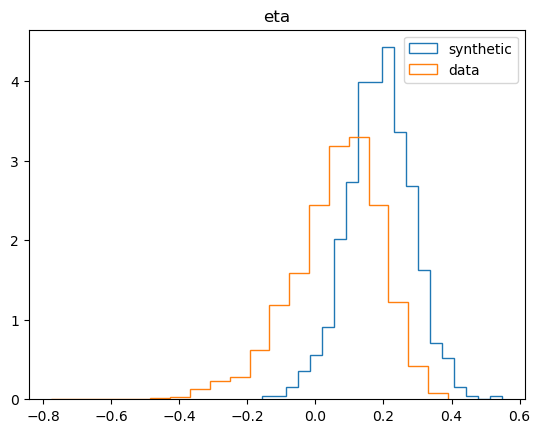

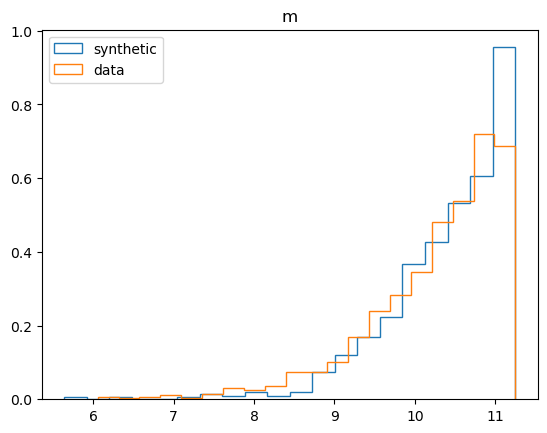

In [64]:
def estimate_data_parameters():
    
    """
    ID   2MASS XSC ID name (HHMMSSss+DDMMSSs)
    RAdeg   Right ascension (J2000)
    DEdeg   Declination (J2000)
    cz2mrs  Heliocentric redshift from the 2MRS (km/s)
    Kmag    NIR magnitudes in the K band from the 2MRS (mag)
    Hmag    NIR magnitudes in the H band from the 2MRS (mag)
    Jmag    NIR magnitudes in the J band from the 2MRS (mag)
    e_Kmag    Error of the NIR magnitudes in K band from the (mag)
    e_Hmag    Error of the NIR magnitudes in H band from the (mag)
    e_Jmag    Error of the NIR magnitudes in J band from the (mag)
    WHIc    Corrected HI width (km/s)
    e_WHIc    Error of corrected HI width (km/s)
    """
    
    columns = ['ID', 'RAdeg', 'DEdeg', 'cz2mrs', 'Kmag', 'Hmag', 'Jmag', 'e_Kmag', 'e_Hmah', 'e_Jmag', 'WHIc', 'e_WHIc']
    fname = '/data101/bartlett/fsigma8/PV_data/2MASS/table1.dat'
    df = pd.read_csv(fname, sep='\s+', names=columns)
    
    sigma_m = np.median(df['e_Kmag'])

    eta = np.log10(df['WHIc']) - 2.5
    sigma_eta = np.median(df['e_WHIc'] / df['WHIc'] / np.log(10))
    
    hyper_eta_mu = np.median(eta)
    hyper_eta_sigma = (np.percentile(eta, 84) - np.percentile(eta, 16)) / 2
    
    return sigma_m, sigma_eta, hyper_eta_mu, hyper_eta_sigma

columns = ['ID', 'RAdeg', 'DEdeg', 'cz2mrs', 'Kmag', 'Hmag', 'Jmag', 'e_Kmag', 'e_Hmah', 'e_Jmag', 'WHIc', 'e_WHIc']
fname = '/data101/bartlett/fsigma8/PV_data/2MASS/table1.dat'
df = pd.read_csv(fname, sep='\s+', names=columns)

# Get some parameters from the data
sigma_m, sigma_eta, hyper_eta_mu, hyper_eta_sigma = estimate_data_parameters()

# cosmo = astropy.cosmology.Planck18
cosmo = LambdaCDM(H0 = 80, Om0 = 0.3, Ode0 = 0.7)

# Other parameters to use
L = 200.0
N = 64
xmin = -L/2
Rmax = 100
Nt = 2062
alpha = 1.4
mthresh = 11.25
a_TFR = -23
b_TFR = -8.2
sigma_TFR = 0.3
bias_epsilon = 1e-7

dens = np.load('dens.npy')
vel = np.load('vel.npy')
N = dens.shape[0]

phi = (1. + dens + bias_epsilon) ** alpha

 # Generate positions (comoving)
xtrue = poisson_process.sample_3d(phi, Nt, L, (xmin, xmin, xmin))

# Convert to RA, Dec, Distance (comoving)
rtrue = np.sqrt(np.sum(xtrue** 2, axis=0))  # Mpc/h
c = SkyCoord(x=xtrue[0], y=xtrue[1], z=xtrue[2], representation_type='cartesian')
RA = c.spherical.lon.degree
Dec = c.spherical.lat.degree
r_hat = np.array(SkyCoord(ra=RA*apu.deg, dec=Dec*apu.deg).cartesian.xyz)

# Compute cosmological redshift
zcosmo = z_at_value(cosmo.comoving_distance, rtrue * apu.Mpc / cosmo.h).value

print('zcosmo', zcosmo.min(), zcosmo.max())
        
# Compute luminosity distance
# DO I NEED TO DO /h???
# dL = (1 + zcosmo) * rtrue  # Mpc/h
dL = cosmo.luminosity_distance(zcosmo).to(apu.Mpc).value # Mpc

# Compute true distance modulus
mutrue = 5 * np.log10(dL) + 25

 # Sample true linewidth (eta) from its prior
etatrue = hyper_eta_mu + hyper_eta_sigma * np.random.randn(Nt)

print('etatrue:', etatrue.min(), etatrue.max())

# Obtain muTFR from mutrue using the intrinsic scatter
muTFR = mutrue + sigma_TFR * np.random.randn(Nt)

print('muTFR', muTFR.min(), muTFR.max())
print('mutrue', mutrue.min(), mutrue.max())
print('sigma_TFR', sigma_TFR)

# Obtain apparent magnitude from the TFR
mtrue = muTFR + (a_TFR + b_TFR * etatrue)

print('mtrue', mtrue.min(), mtrue.max())

# Scatter true observed apparent magnitudes and linewidths
mobs = mtrue + sigma_m * np.random.randn(Nt)
etaobs = etatrue + sigma_eta * np.random.randn(Nt)

# Apply apparement magnitude cut
m = mobs <= mthresh
mobs = mobs[m]
etaobs = etaobs[m]
xtrue = xtrue[:,m]

data_eta = np.log10(df['WHIc']) - 2.5
plt.hist(etaobs, label='synthetic', histtype='step', density=True, bins=20)
plt.hist(data_eta, label='data', histtype='step', density=True, bins=20)
plt.legend()
plt.title('eta')

plt.figure()
data_m = df['Kmag']
plt.hist(mobs, label='synthetic', histtype='step', density=True, bins=20)
plt.hist(data_m, label='data', histtype='step', density=True, bins=20)
plt.legend()
plt.title('m')


In [72]:
L = 500
xmin = - 250
Rmax = 100
N = 64
x = np.linspace(xmin, xmin + L, N+1)
i0 = np.argmin(np.abs(x + Rmax))
i1 = np.argmin(np.abs(x - Rmax))

Lsmall = x[i1] - x[i0]
dens_small = dens[i0:i1, i0:i1, i0:i1]
xmin_small = x[i0]
print(Lsmall)
print(dens_small.shape)
print(xmin_small)

print(x[1] - x[0])
print(L / N)

203.125
(26, 26, 26)
-101.5625
7.8125
7.8125


# Check MB

[STD    ] Building gravity model lpt
[STD    ] | |     ___________                              
[STD    ] | |    /-/_"/-/_/-/|     __________________________ 
[STD    ] | |   /"-/-_"/-_//||                BORG3 model
[STD    ] | |  /__________/|/|     (c) Jens Jasche 2012 - 2019
[STD    ] | |  |"|_'='-]:+|/||        Guilhem Lavaux 2014 - 2019
[STD    ] | |  |-+-|.|_'-"||//     __________________________ 
[STD    ] | |  |[".[:!+-'=|//     
[STD    ] | |  |='!+|-:]|-|/       
[STD    ] | |   ----------         
[STD    ] | | 
[STD    ] | | Please acknowledge the following papers:
[STD    ] | |   - Jasche & Lavaux (A&A, 2019, arXiv 1806.11117)
[STD    ] | |   - Jasche & Wandelt (MNRAS, 2012, arXiv 1203.3639)
[STD    ] | |   - Jasche & Kitaura (MNRAS, 2010, arXiv 0911.2496)
[STD    ] | |   - Lavaux, Jasche & Leclercq (arXiV 1909.06396)
[STD    ] | |   - And relevant papers depending on the used sub-module/contribution
[STD    ] | | 

[STD    ] | | This is BORG version 6b1404bfd8011f03ee1b

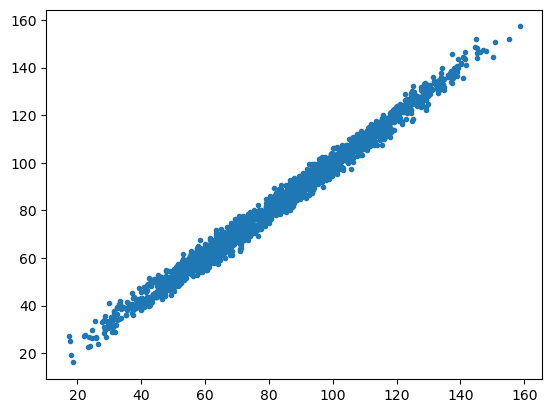

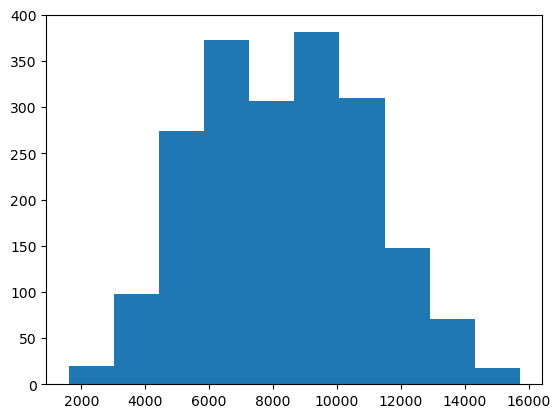

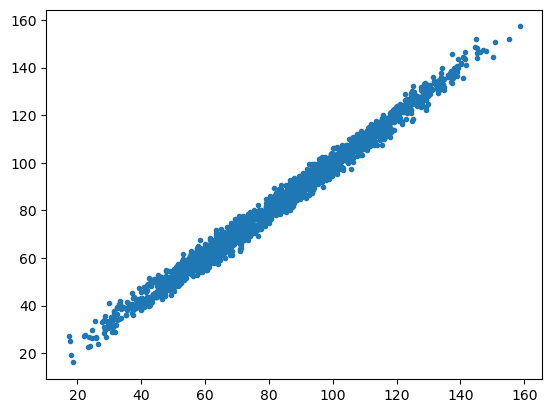

In [44]:
importlib.reload(tfr_inference)

# Get some parameters from the data
sigma_m, sigma_eta, hyper_eta_mu, hyper_eta_sigma = tfr_inference.estimate_data_parameters()

# Other parameters to use
L = 500.0
N = 64
xmin = -L/2
R_lim = L / 2
Rmax = 100
Nt = 2000
alpha = 1.4
mthresh = 11.25
a_TFR = -23
b_TFR = -8.2
sigma_TFR = 0.3
sigma_v = 150
Nint_points = 201 
Nsig = 10
frac_sigma_r = 0.07  # WANT A BETTER WAY OF DOING THIS - ESTIMATE THROUGH SIGMAS FROM TFR
interp_order = 1
bias_epsilon = 1.e-7

cpar, dens, vel = tfr_inference.get_fields(L, N, xmin)

RA, Dec, czCMB, m_true, eta_true, m_obs, eta_obs, xtrue = tfr_inference.create_mock(
        Nt, L, xmin, cpar, dens, vel, Rmax, alpha, mthresh,
        a_TFR, b_TFR, sigma_TFR, sigma_m, sigma_eta, 
        hyper_eta_mu, hyper_eta_sigma, sigma_v, 
        interp_order=interp_order, bias_epsilon=bias_epsilon)


plt.figure()
rtrue = jnp.sqrt(jnp.sum(xtrue ** 2, axis=0))
robs = czCMB / 100 
plt.plot(rtrue, robs, '.')
    
MB_pos = tfr_inference.generateMBData(RA, Dec, czCMB, L, N, R_lim, Nsig, Nint_points, sigma_v, frac_sigma_r)
r = jnp.sqrt(jnp.sum(MB_pos ** 2, axis=0))

rtrue = jnp.sqrt(jnp.sum(xtrue ** 2, axis=0))

for i in range(3):
    print(r[i,0], r[i,-1], rtrue[i])
    
# Check truth always inside the range of the MB pos
dr_low = rtrue - r[:,0]
dr_high = r[:,-1] - rtrue
m = dr_low < 0
print(m.sum())
m = dr_high < 0
print(m.sum())
print('Low:', dr_low.min())
print('High', dr_high.min())
print(r.min(), r.max())

czCMB_new = ((1 + zcosmo) * (1 + vr_noised / tfr_inference.utils.speed_of_light) - 1) * tfr_inference. utils.speed_of_light

plt.figure()

In [1]:
import numpy as np
import matplotlib.pyplot as plt

(array([107., 113.,  94., 108., 100.,  93., 110.,  95.,  86.,  94.]),
 array([-1.99562025, -1.59607887, -1.19653749, -0.79699612, -0.39745474,
         0.00208664,  0.40162802,  0.8011694 ,  1.20071077,  1.60025215,
         1.99979353]),
 <BarContainer object of 10 artists>)

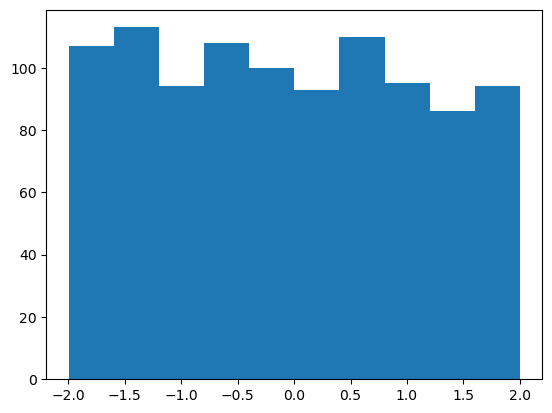

In [3]:
a = np.loadtxt('a.txt')
plt.hist(a)